# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [320]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

import warnings
warnings.filterwarnings('ignore')

In [321]:
!wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv

--2024-05-14 20:35:54--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8829280 (8.4M) [text/plain]
Saving to: ‘tweets_coronavirus.csv’

tweets_coronavirus. 100%[===================>]   8.42M  --.-KB/s    in 0.02s   

2024-05-14 20:35:54 (366 MB/s) - ‘tweets_coronavirus.csv’ saved [8829280/8829280]



In [322]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
312,4181,49133,NaN,16-03-2020,#MondayMotivation: If this #QuarantineLife ove...,Negative
10677,16754,61706,NaN,21-03-2020,I hate when I go to the store to see food and ...,Extremely Negative
29833,40427,85379,Washington State,09-04-2020,Saw someone who just did not get the point of ...,Positive
158,3989,48941,London | New York | Munich,16-03-2020,"""I already stocked up on food. Ammo was just t...",Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [323]:
set(df['Sentiment'])

{'Extremely Negative', 'Extremely Positive', 'Negative', 'Positive'}

In [324]:
# Заметим, что в столбце Sentiment присутствуют 4 значения. Соответственно,
# отнесем положительные к классу 1, а отрицательные к 0.

def convertValue(value):
    if value in ['Positive', 'Extremely Positive']:
        return 1
    return 0

df['Sentiment'] = df['Sentiment'].apply(convertValue, convert_dtype=int)

Сбалансированы ли классы?

In [325]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:**
Как мы видим к классу 1 относится ~ 54%, а к классу 0 ~ 46%. Соответственно, можно сказать что классы довольно сбалансированы.

---

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [326]:
df.isna().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [327]:
# Мы видим, что в данных присутствуют пропуски, но только в столбце Location.
# Заполним их, как нас и просят

df = df.fillna('Unknown')

In [328]:
print(f'Количество пропусков в таблице: {df.isna().sum().sum()}\nУра! Пропусков не осталось')

Количество пропусков в таблице: 0
Ура! Пропусков не осталось


---

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [329]:
# Просто сделаем все по заданию: разделим выборки и сделаем stratify по столбцу
# таргетов (чтобы классы остались сбалансированными).

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.7, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведением токенов в нижний регистр

In [330]:
# Используем надстройку над словарем - Counter
from collections import Counter

# Функция добавляющая наше слово в словарь (в нижнем регистре)
def AddWord(word):
    global wordsDictionary
    word = word.lower()
    if word in wordsDictionary:
        wordsDictionary[word] += 1
    else:
        wordsDictionary[word] = 1


wordsDictionary = Counter()
# Применим функцию к каждому слову из каждого текста в нашей таблице
train['OriginalTweet'].apply(lambda text: [AddWord(word) for word in text.split()])
# Проверим, что все считается
wordsDictionary.most_common(10)

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

---

Какой размер словаря получился?

In [331]:
print(f'Размер словаря: {len(wordsDictionary)}')

Размер словаря: 79755


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [332]:
# выводим 10 самых популярных слов
wordsDictionary.most_common(10)

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:**

Самыми популярными словами стали артикли ('a', 'the'), так как они используются почти всегда перед существительными. Также в топе предлоги, которые являются словами-связками и используются между словами ('to', 'of', 'in', 'for'). Союз 'and' так же очень популярен, так как и в русском языке мы часто используем союз И для связи частей предложений, однородных членов и тд.

Отдельно выделяется хэштег '#coronavirus', так как этот датасет состоит из твитов о коронавирусе.

И, конечно же, в топе присутствует глагол to be в формах 'is', 'are'. Потому что эти глаголы часто встречаются в английских грамматических конструкциях.

---

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [333]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [334]:
# функция проверяющая, есть ли слово в stopwords и удаляющая его, если что
def CheckWord(word):
    global wordsDictionary
    if word in stopwords.words("english"):
        del wordsDictionary[word]

words = list(wordsDictionary)
# тут такая конструкция, чтобы не писать циклом, но применить ко всем элементам)
# просто map не выполнит функцию (из-за оптимизации), поэтому мы передаем
# результат в ф-цию list и тогда мы получаем желаемый результат
list(map(CheckWord, words))

wordsDictionary.most_common(10)

[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:**  теперь, все служебные части речи ушли и остались только слова со смыслом.

Опять же очень популярным остался '#coronavirus', к нему добавились 'covid-19', '#covid19' это связано с тем, что твиты были о коронавирусе.

'prices', 'food' и 'grocery', 'supermarket', 'store' было популярным, вероятно из-за подъема цен на продукты в магазинах, а так же из-за изменения режимов работы и правил посещения магазинов.

'people' может быть потому что всем было интересно сколько людей заболело и они часто проверяли и писали об этом.

---

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [335]:
# Выведем 20 самых  непопулярных
wordsDictionary.most_common()[-1:-21:-1]

[('https://t.co/7j2y3rsld9', 1),
 ('@680news', 1),
 ('@torontopearson', 1),
 ('nothing...', 1),
 ('flew', 1),
 ('wage!', 1),
 ('renewing', 1),
 ('playersã\x82â\x92', 1),
 ('subsidise', 1),
 ('non-playing', 1),
 ('premiership', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('#southkerry', 1),
 ('#skelligcoast2kms', 1),
 ('@skelligsix18', 1),
 ('closer!)', 1),
 ('coast!', 1),
 ('skellig', 1)]

**Ответ:** Самые непопулярные слова - это слова встретившиеся ровно 1 раз.

Такими оказались ссылки. Их вероятно лучше удалить из наших данных, так как они не дают никакой полезной информации.

Также туда попали непопулярные и сложные слова. С ними ничего не нужно делать, они просто редкие.

Выделяются слова, которые просто неправильно разделились пробелами. То есть слова с точками, скобками и другими знаками препинания: 'playersã\x82â\x92' и другие. Стоит делить слова правильнее, чтобы таких ситуаций не возникало, потому что с важными словами рядом могут стоять знаки препинания и тогда мы не узнаем об этих важных словах.

---


Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [336]:
from nltk.tokenize import TweetTokenizer


# Функция добавляющая наше слово в словарь (в нижнем регистре)
def AddWordTweet(word):
    global wordsDictionaryTweet
    if word in wordsDictionaryTweet:
        wordsDictionaryTweet[word] += 1
    else:
        wordsDictionaryTweet[word] = 1


tokenizer = TweetTokenizer()

wordsDictionaryTweet = Counter()
# Применим функцию к каждому слову из каждого текста в нашей таблице
train['OriginalTweet'].apply(lambda text: [AddWordTweet(word) for word in tokenizer.tokenize(text)])
wordsDictionaryTweet.most_common(10)

[('the', 24337),
 ('.', 24118),
 ('to', 22933),
 (',', 17571),
 ('and', 14354),
 ('of', 12904),
 ('a', 11045),
 ('in', 10573),
 ('?', 9524),
 ('for', 8228)]

**Ответ:** тут мы тоже получили, что самыми популярными являются служебные части речи. Однако, добавились знаки препинания, а значит TweetTokenizer получше разделил текст, и вероятно, теперь слова слитно написанные со знаками препинания считаются правильно.

---

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [337]:
from string import punctuation

# функция проверяющая, есть ли слово в stopwords и удаляющая его, если что
# если использовать только punctation без многоточия, то оно будет часто
# использоваться и будет 10-тым по популярности.
# Но нас просят убрать всю пунктуацию, поэтому отдельно уберем и его тоже
def CheckWordTweet(word):
    global wordsDictionaryTweet
    if word in stopwords.words("english") or word in punctuation:
        del wordsDictionaryTweet[word]

wordsTweet = list(wordsDictionaryTweet)
list(map(CheckWordTweet, wordsTweet))

wordsDictionaryTweet.most_common(10)

[('Â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('#coronavirus', 7143),
 ('I', 5235),
 ('\x92', 4372),
 ('prices', 4281),
 ('COVID', 4218),
 ('food', 3795),
 ('store', 3691)]

**Ответ:** сразу заметно, что теперь у нас на первые места в топе вышли непонятные символы '\x82', '\x92' - которые вероятно просто не смогли правильно раскодироваться. Также здесь символ 'Â', может быть пользователи реально часто его используют, а может быть опять же ошибка кодировки.

У нас в топе добавилась буква 'I' (Я по-английски), как и в русском языке она часто используется.

Остальные слова довольно похожи на те, что мы получили в первый раз.

 ---

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [338]:
words = list(wordsDictionaryTweet)

# Функция проверяет на соответствие условию и если что, удаляет слово
def deleteUnicode(word):
    if len(word) == 1 and ord(word) >= 128:
        del wordsDictionaryTweet[word]

list(map(deleteUnicode, words))
# Топ 10 по популярности
wordsDictionaryTweet.most_common(10)

[('19', 7167),
 ('#coronavirus', 7143),
 ('I', 5235),
 ('prices', 4281),
 ('COVID', 4218),
 ('food', 3795),
 ('store', 3691),
 ('supermarket', 3373),
 ('grocery', 3083),
 ('people', 3047)]

In [339]:
# Выведем 20 самых  непопулярных
wordsDictionaryTweet.most_common()[-1:-21:-1]

[('https://t.co/7j2Y3rSld9', 1),
 ('@680NEWS', 1),
 ('@TorontoPearson', 1),
 ('flew', 1),
 ('renewing', 1),
 ('playersÃ', 1),
 ('subsidise', 1),
 ('non-playing', 1),
 ('premiership', 1),
 ('Vile', 1),
 ('https://t.co/IAEK4fWsgz', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/zJcL195VQS', 1),
 ('#SouthKerry', 1),
 ('#SkelligCoast2kms', 1),
 ('@SkelligSix18', 1),
 ('Skellig', 1),
 ('milion', 1),
 ('now.When', 1),
 ('ruins', 1)]

**Ответ:**

<u>САМЫЕ ПОПУЛЯРНЫЕ</u>

Теперь самые популярные слова выглядят гораздо лучше. '19', '#coronavirus', 'COVID' тут есть, так как твиты о коронавирусе.

'I' - так как часто используется в языке (вообще она в стоп-словах, но так как здесь она заглавная, то она не удалилась).

'prices', 'food', 'store', 'supermarket', 'grocery' - из-за того что цены на продукты и еду росли в тот период.

'people' - всем было интересно, сколько людей сейчас болеет и вообще статистика по людям.

<u>САМЫЕ НЕПОПУЛЯРНЫЕ</u>

Здесь остались ссылки, редкие слова не совсем по теме.

---

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [340]:
counter = 0
for word, count in wordsDictionaryTweet.most_common():
    if counter == 10:
        break
    if word.startswith('#'):
        print(word, count)
        counter += 1

#coronavirus 7143
#COVID19 1844
#Covid_19 1463
#Coronavirus 1281
#COVID2019 927
#toiletpaper 657
#covid19 568
#COVID 542
#CoronaCrisis 426
#CoronaVirus 351


**Ответ:** мы видим, что люди очень часто использовали хэштеги связанные с коронавирусом и его названием (чтобы показать, что их твит относится к этой теме).

Отдельно видно хэштег #toiletpaper - он просто связан с кризисом туалетной бумаги.

---

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [341]:
counter = 0
for word, count in wordsDictionaryTweet.most_common():
    if counter == 10:
        break
    if word.startswith('https://t.co'):
        print(word, count)
        counter += 1

https://t.co/oXA7SWtoNd 5
https://t.co/gP3EusapL8 4
https://t.co/DefTruI1PfÃÂ 3
https://t.co/WrLHYzIzAA 3
https://t.co/kuwIpF1KQW 3
https://t.co/zjNRx6dKKN 3
https://t.co/3GBBDpdjat 3
https://t.co/e2ZNXajPre 3
https://t.co/CATKegAyOY 3
https://t.co/G63RP042HO 3


**Ответ:** ссылки уникальные и в адресе используется какую-то сгенерированную рандомно последовательность / хэш-код, поэтому никакой полезной информации для нас они не содержат.

Популярность ссылок несравнима с популярностью хэштегов.

---

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [342]:
import nltk
from nltk.corpus import stopwords
from string import punctuation

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [343]:
# Просто напишем то, что требуется по условию
def custom_tokenizer(text):
    # Переводим в нижний регистр
    text = text.lower()

    # Токенизируем
    tokenizer = TweetTokenizer()
    tokens_raw = tokenizer.tokenize(text)

    # Убираем лишние токены
    noise = stopwords.words("english") + list(punctuation)
    tokens = [word for word in tokens_raw
                       if not ((word in noise) or
                               (len(word) == 1 and ord(word) >= 128) or
                               (word.startswith("https://t.co")))]
    return tokens

In [344]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [345]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

45308


**Ответ**

```
Прошлый размер словаря: 79755
Новый размер словаря:   45308
```

Как мы видим, мы серьезно уменьшили наш словарь, изменив подход и убрав оттуда ненужный мусор.

---

Посмотрим на какой-нибудь конкретный твитт:

In [346]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [347]:
result = cv.transform([train.iloc[ind]['OriginalTweet']])
result = result.toarray()
tokens = cv.get_feature_names_out()

words_counted = []

for index in range(len(tokens)):
    if result[0][index] != 0:
        words_counted.append((result[0][index], tokens[index]))

sorted(words_counted, reverse=True)

[(1, 'show'),
 (1, 'queueing'),
 (1, 'ppl'),
 (1, 'panic'),
 (1, 'one'),
 (1, 'nice'),
 (1, 'lets'),
 (1, 'france'),
 (1, 'food'),
 (1, 'ffs'),
 (1, 'brainless'),
 (1, '@skynews'),
 (1, '#covid2019'),
 (1, '#coronavirusoutbreak')]

**Ответ:** Видно, что все слова используются по одному разу, поэтому CountVectorizer не смог определить, какие из них важнее и они все имеет вес 1. (Это плохо)

---

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [348]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(tokenizer=custom_tokenizer)
tfv.fit(train['OriginalTweet'])

result_tf = tfv.transform([train.iloc[ind]['OriginalTweet']])
result_tf = result_tf.toarray()
tokens_tf = tfv.get_feature_names_out()

words_counted_tf = []

for index in range(len(tokens_tf)):
    if result_tf[0][index] != 0:
        words_counted_tf.append((result_tf[0][index], tokens_tf[index]))

sorted(words_counted_tf, reverse=True)

[(0.38676411704663755, 'brainless'),
 (0.3543455633321655, 'queueing'),
 (0.3244741764513268, 'ffs'),
 (0.3204731404653966, 'france'),
 (0.31042634466284263, '@skynews'),
 (0.30121070136861045, 'lets'),
 (0.2550064610386691, 'ppl'),
 (0.2542729176022132, 'nice'),
 (0.24406492401820118, 'show'),
 (0.22584265007428547, '#coronavirusoutbreak'),
 (0.16825192939361902, '#covid2019'),
 (0.16306722855395075, 'one'),
 (0.14759470306326167, 'panic'),
 (0.11328893069250723, 'food')]

**Ответ**

Можно сказать, что токены хорошо определились - твит отрицательный, поэтому самое важное слово brainless.

---

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [349]:
train[train['OriginalTweet'].apply(lambda x: 'fascinating' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
27777,37849,82801,"Norfolk County, Ontario",08-04-2020,StatCan Study: Canadian consumers prepare for ...,1
19989,28169,73121,Baltimore,26-03-2020,"really fascinating how HEB, a supermarket chai...",1
28048,38196,83148,New Jersey,08-04-2020,Really fascinating look at how consumer behavi...,1
22767,31620,76572,United Kingdom,03-04-2020,WimbledonÃÂs only strawberry? provider @Hugh...,1
8677,14341,59293,"New York, NY",20-03-2020,Really fascinating moment in food retail as th...,1
17765,25410,70362,"Burlington, VT",25-03-2020,This is a fascinating view COVID-19 trends and...,1


In [350]:
# Будем рассматривать твит 9066
ind = 17765
# Для начала полностью выведем его текст
print(train.loc[ind]['OriginalTweet'])

# Получим результаты TfidfVectorizer
result_tf = tfv.transform([train.loc[ind]['OriginalTweet']])
result_tf = result_tf.toarray()
tokens_tf = tfv.get_feature_names_out()

# Красиво выведем эти результаты
words_counted_tf = []
for index in range(len(tokens_tf)):
    if result_tf[0][index] != 0:
        words_counted_tf.append((result_tf[0][index], tokens_tf[index]))

sorted(words_counted_tf, reverse=True)

This is a fascinating view COVID-19 trends and consumer impact from Glimpse: https://t.co/6sUs6IOSxB https://t.co/ChczCmeenT


[(0.5405780248835753, 'glimpse'),
 (0.4765071724543985, 'fascinating'),
 (0.4181028907097591, 'view'),
 (0.3852964269033738, 'trends'),
 (0.28996118585140523, 'impact'),
 (0.19515461269767173, 'consumer'),
 (0.1367073275322579, 'covid'),
 (0.1288458158015994, '19')]

**Ответ:** в данном примере мы выделели самыми важными 'glimpse' and 'fascinating'. Первое - это название какого-то агенства, а второе слово показывает отношение - fascinating (очень интересно), то есть твит положительно окрашенный.

---

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [351]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Применяем векторайзер
cv = CountVectorizer(tokenizer=custom_tokenizer)
X_train_cv = cv.fit_transform(train['OriginalTweet'])
X_test_cv = cv.transform(test['OriginalTweet'])

# И второй тоже
tfv = TfidfVectorizer(tokenizer=custom_tokenizer)
X_train_tfv = tfv.fit_transform(train['OriginalTweet'])
X_test_tfv = tfv.transform(test['OriginalTweet'])

# Выделяем целевую переменную
y_train = train['Sentiment']
y_test = test['Sentiment']

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [352]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print("==== CountVectorizer ====")
model_cv = LogisticRegression()
model_cv.fit(X_train_cv, y_train)

y_train_pred_cv = model_cv.predict(X_train_cv)
y_test_pred_cv = model_cv.predict(X_test_cv)
print(f'Accuracy on train:  {accuracy_score(y_train, y_train_pred_cv):.3f}')
print(f'Accuracy on test:   {accuracy_score(y_test, y_test_pred_cv):.3f}')

print("==== TfidfVectorizer ====")
model_tfv = LogisticRegression()
model_tfv.fit(X_train_tfv, y_train)

y_train_pred_tfv = model_tfv.predict(X_train_tfv)
y_test_pred_tfv = model_tfv.predict(X_test_tfv)
print(f'Accuracy on train:  {accuracy_score(y_train, y_train_pred_tfv):.3f}')
print(f'Accuracy on test:   {accuracy_score(y_test, y_test_pred_tfv):.3f}')

==== CountVectorizer ====
Accuracy on train:  0.984
Accuracy on test:   0.867
==== TfidfVectorizer ====
Accuracy on train:  0.925
Accuracy on test:   0.853


**Ответ:** как можно заметить первая  точно переобучилась, вторая вероятно тоже, но гораздо меньше. Хотя по значениям accuracy на тесте мы также видим, что несмотря на переобучение первая модель довольно хорошо справилась с задачей (лучше чем Tfidf).

---

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [353]:
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
    stemmer = SnowballStemmer("english")
    tokens = [stemmer.stem(word) for word in custom_tokenizer(text)]
    return tokens

In [354]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [355]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Обучаем векторайзеры
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit(train['OriginalTweet'])
tfv = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tfv.fit(train['OriginalTweet'])

print(f'Размер словаря: {len(cv.vocabulary_)}')

Размер словаря: 36652


**Ответ** размер нашего словаря еще уменьшился, значит мы сделали все правильно, теперь разные формы слов рассматриваются как одно и то же слово.

---

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [356]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train_cv_stem = cv.transform(train['OriginalTweet'])
X_test_cv_stem = cv.transform(test['OriginalTweet'])
X_train_tfv_stem = tfv.transform(train['OriginalTweet'])
X_test_tfv_stem = tfv.transform(test['OriginalTweet'])

print("==== CountVectorizer ====")
model_cv.fit(X_train_cv_stem, y_train)

y_train_pred_cv_stem = model_cv.predict(X_train_cv_stem)
y_test_pred_cv_stem = model_cv.predict(X_test_cv_stem)
print(f'Accuracy on train:  {accuracy_score(y_train, y_train_pred_cv_stem):.3f}')
print(f'Accuracy on test:   {accuracy_score(y_test, y_test_pred_cv_stem):.3f}')

print("==== TfidfVectorizer ====")
model_tfv.fit(X_train_tfv_stem, y_train)

y_train_pred_tfv_stem = model_tfv.predict(X_train_tfv_stem)
y_test_pred_tfv_stem = model_tfv.predict(X_test_tfv_stem)
print(f'Accuracy on train:  {accuracy_score(y_train, y_train_pred_tfv_stem):.3f}')
print(f'Accuracy on test:   {accuracy_score(y_test, y_test_pred_tfv_stem):.3f}')

==== CountVectorizer ====
Accuracy on train:  0.972
Accuracy on test:   0.867
==== TfidfVectorizer ====
Accuracy on train:  0.916
Accuracy on test:   0.856


**Ответ:** по результатам видно, что проблема переобучения при стемминге менее выраженна. Да и результаты на тестовой выборке стали лучше, поэтому использовать стемминг это хорошо.

```
           OLD                        WITH STEM
==== CountVectorizer ====     ==== CountVectorizer ====
Accuracy on train:  0.984     Accuracy on train:  0.972
Accuracy on test:   0.867     Accuracy on test:   0.867
==== TfidfVectorizer ====     ==== TfidfVectorizer ====
Accuracy on train:  0.925     Accuracy on train:  0.916
Accuracy on test:   0.853     Accuracy on test:   0.856
```

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [357]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8000).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

36651


**Ответ:** параметр получился большим, так как нам нужно убрать всего один объект, а так как это max_df, то мы убираем самый большой элемент => его значение довольно большое, поэтому нам нужно взять значение такое же большое.

---

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [358]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

3700


**Ответ:** тут значение получилось маленькое, так как много токенов, которые не часто встречаются (2-10 раз) и мы хотим сократить словарь, но не сильно, поэтому мы делаем значение средне маленьким.

---

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [359]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11)
cv_df.fit(df['OriginalTweet'])
X_train = pd.DataFrame(cv_df.transform(train['OriginalTweet']).toarray(), columns=cv_df.get_feature_names_out())
X_test = pd.DataFrame(cv_df.transform(test['OriginalTweet']).toarray(), columns=cv_df.get_feature_names_out())
print(len(cv_df.vocabulary_))

scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


model_cv = LogisticRegression()
model_cv.fit(X_train_scaled, y_train)

y_train_pred = model_cv.predict(X_train_scaled)
y_test_pred = model_cv.predict(X_test_scaled)
print(f'Accuracy on train:  {accuracy_score(y_train, y_train_pred):.3f}')
print(f'Accuracy on test:   {accuracy_score(y_test, y_test_pred):.3f}')

4593
Accuracy on train:  0.963
Accuracy on test:   0.827


```
           OLD                      OLD WITH STEM
==== CountVectorizer ====     ==== CountVectorizer ====
Accuracy on train:  0.984     Accuracy on train:  0.972
Accuracy on test:   0.867     Accuracy on test:   0.867
==== TfidfVectorizer ====     ==== TfidfVectorizer ====
Accuracy on train:  0.925     Accuracy on train:  0.916
Accuracy on test:   0.853     Accuracy on test:   0.856
```

Результаты получились самыми плохими для тестовой выборки...

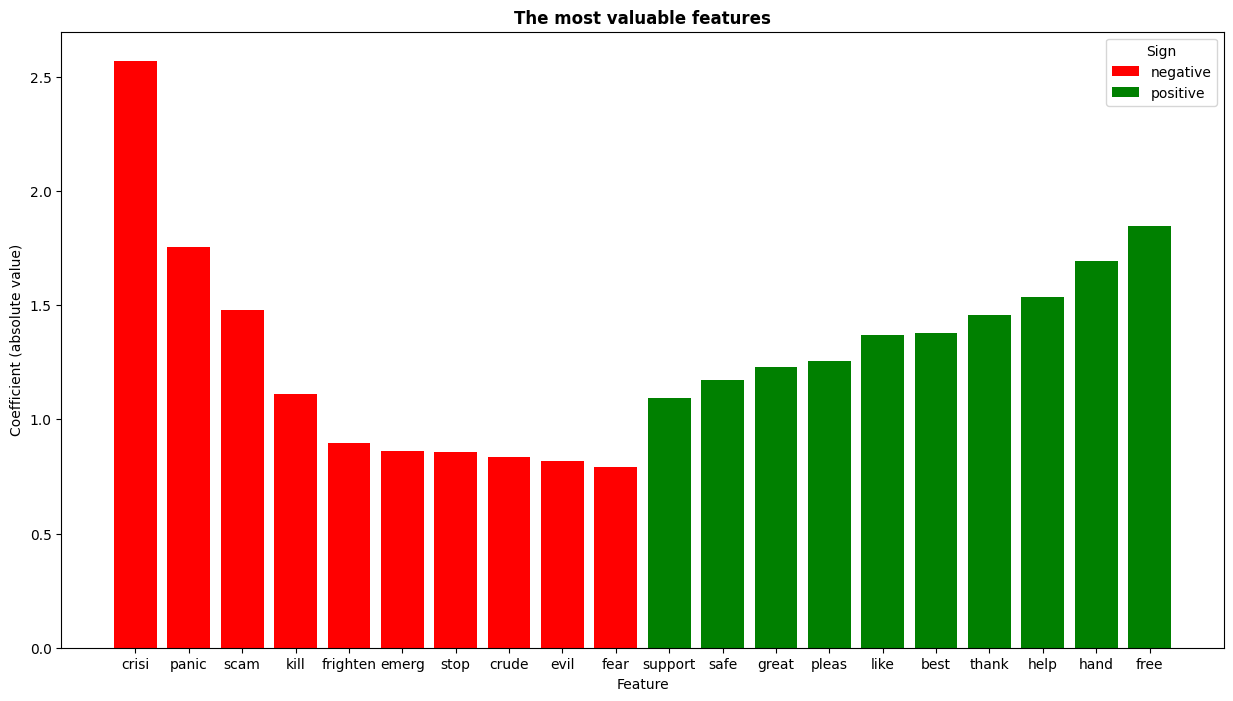

In [360]:
# тут просто строим график
coefs = np.argsort((model_cv.coef_[0]))
coefs = np.concatenate((coefs[:10], coefs[-10:]))

names = cv_df.get_feature_names_out()[coefs]
values = abs(model_cv.coef_[0][coefs])

help = np.vectorize(lambda value: 'green' if value >= 0 else 'red')(model_cv.coef_[0][coefs])
bar_labels = np.vectorize(lambda color: '_' + ('positive' if color == 'green' else 'negative'))(help)
if np.any(np.isin('_positive', bar_labels)):
    bar_labels[np.where(bar_labels == '_positive')[0][0]] = 'positive'
if np.any(np.isin('_negative', bar_labels)):
    bar_labels[np.where(bar_labels == '_negative')[0][0]] = 'negative'

plt.figure(figsize=(15,8))
plt.bar(names, values, color=help, label=bar_labels)
plt.title('The most valuable features', fontweight='bold')
plt.xlabel('Feature')
plt.ylabel('Coefficient (absolute value)')
plt.legend(title='Sign')
plt.show()

**Ответ:** можно сказать, что логистическая регрессия довольно хорошо справилась с задачей выделения важных токенов.

Среди признаков с большими положительными коэффициентами есть только хорошие слова, которые реально показывают принадлежность к положительным комментариям: 'support', 'free', 'help', 'thank', 'best' и т.д.

Среди отрицательных - самое плохое, это 'crisi' (вероятно 'crisis' - кризис), затем 'panic', 'scam', 'kill' и т.д. Все это показывает, что комментарий скорей всего отрицательный.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [361]:
size = len(df['UserName'])
distinct_size = len(set(df['UserName']))
size_sc = len(df['ScreenName'])
distinct_size_sc = len(set(df['ScreenName']))
print('================ UserName ================')
print(f'Размер столбца UserName:             { size }')
print(f'Количество различных значений в нем: { distinct_size }')
print('=============== ScreenName ===============')
print(f'Размер столбца ScreenName:           { size_sc }')
print(f'Количество различных значений в нем: { distinct_size_sc }')

================ UserName ================
Размер столбца UserName:             33444
Количество различных значений в нем: 33444
=============== ScreenName ===============
Размер столбца ScreenName:           33444
Количество различных значений в нем: 33444


**Ответ:** как мы видим, все значения в столбцах UserName и ScreenName различны, а значит и никаких закономерностей в них мы не найдем (все значения независимы друг от друга, это просто идентификаторы пользователей) => **не будем использовать признаки UserName и ScreenName**.

---

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

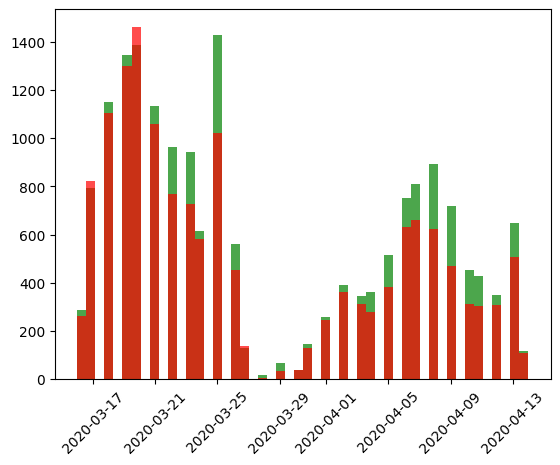

In [362]:
import datetime

format = '%d-%m-%Y'

newTweetAt = np.vectorize(lambda value: datetime.datetime.strptime(value, format))(df['TweetAt'])
plt.hist(newTweetAt[np.argwhere(df['Sentiment'] == 1)], bins=50, color='green', alpha=0.7)
plt.hist(newTweetAt[np.argwhere(df['Sentiment'] != 1)], bins=50, color='red', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

**Ответ:** можно заметить, что почти во все дни количество отрицательных твитов совпадает с положительными, то есть дата не особо влияет на результат => **TweetAt практически бесполезный, не будем использовать**

---


Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [363]:
print('Количество уникальных значений в столбце Location: ' + str(len(set(df['Location']))) + '\n')
df['Location'].value_counts()

Количество уникальных значений в столбце Location: 10465



Location
Unknown                         7052
London                           435
United States                    416
London, England                  413
Washington, DC                   317
                                ... 
Kolkata & Howrah                   1
Egypt/UK                           1
Sky Poker obviously                1
Somerset, UK                       1
3052 Dubois Road, Ithaca, NY       1
Name: count, Length: 10465, dtype: int64

В столбце Location мы видим, что количество уникальных значений в несколько раз меньше, чем количество объектов (10465 значений на 33444 объекта) => есть объекты с одинаковыми значениями (например 435 - London, 416 - United States) и, возможно из этих данных мы сможем получить полезную информацию.

Это объясняется и географией, зачастую характеры людей в разных странах отличаются => и их твиты тоже.

---

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

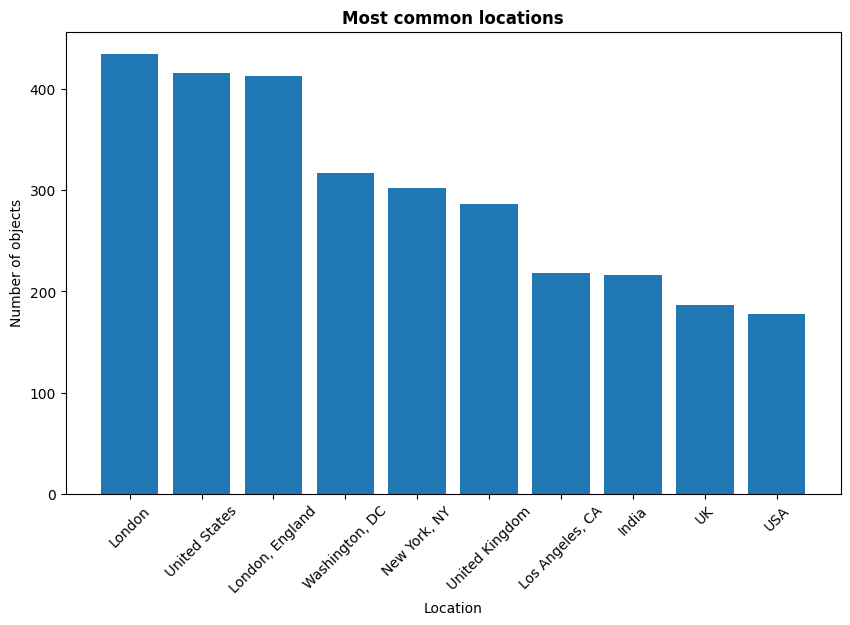

In [364]:
# Достаем местоположения и сколько раз они встречаются (отсортированные)
top_location = df['Location'].value_counts()[:11]
top_location.drop(index='Unknown', inplace=True)

# Строим график
plt.figure(figsize=(10,6))
plt.title('Most common locations', fontweight='bold')
plt.xlabel('Location')
plt.ylabel('Number of objects')
plt.bar(top_location.index, top_location.values)
plt.xticks(rotation=45)
plt.show()

---

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [365]:
# Функция обрабатывающая местоположение
# Делит название по запятым, берет последнее значение без пробелов
# А также немного обрабатывает в ручную частные случаи (например, многие
# штаты в США записываются двумя буквами, но все они в Америке: CA, GA, TX...)
def defineWiderLocation(location):
    location = location.split(',')[-1].strip()
    if location in ['Texas', 'New York', 'United States'] or (len(location) == 2 and location == location.upper()):
        location = 'USA'
    elif location in ['England', 'UK', 'London']:
        location = 'United Kingdom'
    elif location in ['Ontario']:
        location = 'Canada'
    return location

# Обрабатываем все значения для правильной статистики
df['WiderLocation'] = np.vectorize(defineWiderLocation)(df['Location'])
print('Новое количество уникальных значений: ' + str(len(set(df['WiderLocation']))))

# Также не забываем про наши выборки
train['WiderLocation'] = np.vectorize(defineWiderLocation)(train['Location'])
test['WiderLocation'] = np.vectorize(defineWiderLocation)(test['Location'])

Новое количество уникальных значений: 6022


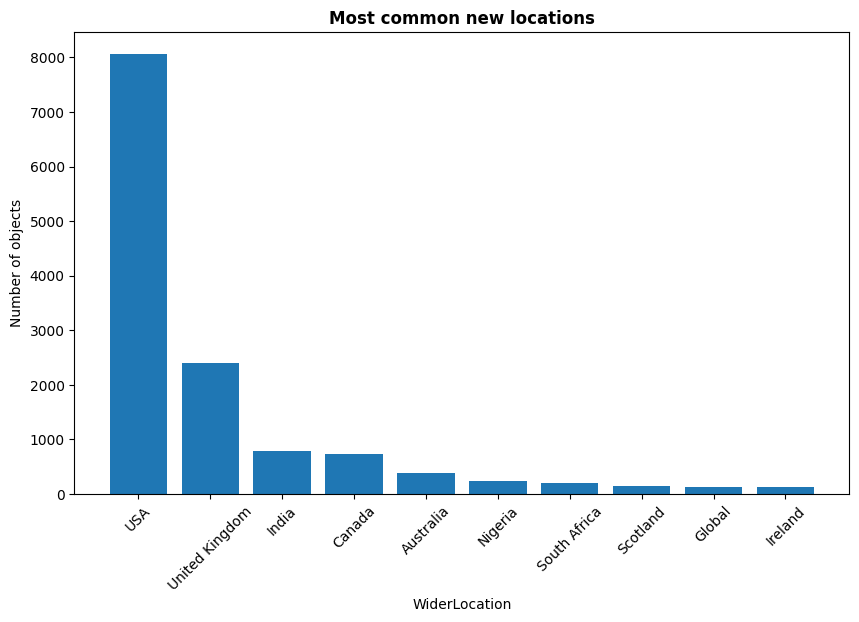

In [366]:
# Достаем значения (как раньше)
top_location = df['WiderLocation'].value_counts()[:11]
top_location.drop(index='Unknown', inplace=True)

# Строим график
plt.figure(figsize=(10,6))
plt.title('Most common new locations', fontweight='bold')
plt.xlabel('WiderLocation')
plt.ylabel('Number of objects')
plt.bar(top_location.index, top_location.values)
plt.xticks(rotation=45)
plt.show()

Было замечено, что все названия написаны через запятую, поэтому была выбрана стратегия делить по запятой, а затем брать последнее слова и убирать пробелы сначала и конца. Затем вручную были выбраны и соединены самые популярные Локации написанные разными словами. А еще, зачастую штаты в USA записываются двумя заглавными буквами (CA, GA, TX...) и это мы тоже выделили отдельно в United States.

Нам удалось сократить количество уникальных значений с 10465 до 6022. По диаграмме также видно, что у нас теперь значения распределены гораздо правильнее (практически по странам).

---

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [367]:
from sklearn.preprocessing import OneHotEncoder

# Инициализируем энкодер
encoder = OneHotEncoder(sparse_output=False, dtype=bool, min_frequency=2)

# Обучаем энкодер на всей выборке, так как в тесте могут быть новые значения,
# необработанные при обучении на трэйне
encoder.fit(df[['WiderLocation']])

# Получаем закодированный train
ohe_train = encoder.transform(train[['WiderLocation']])
ohe_df_train = pd.DataFrame(ohe_train, columns=encoder.get_feature_names_out(['WiderLocation']))

# Получаем закодированный test
ohe_test = encoder.transform(test[['WiderLocation']])
ohe_df_test = pd.DataFrame(ohe_test, columns=encoder.get_feature_names_out(['WiderLocation']))

print(f'Различных значений местоположения, которые встречаются более одного раза: {ohe_df_train.shape[1]}')
print('(Для всей выборки!!)')

Различных значений местоположения, которые встречаются более одного раза: 1232
(Для всей выборки!!)


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [368]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=scaler.get_feature_names_out()).reset_index()
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=scaler.get_feature_names_out()).reset_index()

X_train_scaled_encoded = pd.concat([X_train_scaled_df, ohe_df_train], axis=1)
X_test_scaled_encoded = pd.concat([X_test_scaled_df, ohe_df_test], axis=1)

In [369]:
model_cv = LogisticRegression()
model_cv.fit(X_train_scaled_encoded, y_train)

y_train_pred = model_cv.predict(X_train_scaled_encoded)
y_test_pred = model_cv.predict(X_test_scaled_encoded)
print(f'Accuracy on train:  {accuracy_score(y_train, y_train_pred):.3f}')
print(f'Accuracy on test:   {accuracy_score(y_test, y_test_pred):.3f}')

Accuracy on train:  0.941
Accuracy on test:   0.846


**Ответ:** сравним с предыдущим результатом:

```
                    Previous  Current
Accuracy on train:  0.963     0.941
Accuracy on test:   0.827     0.846
```

Как мы видим, теперь мы еще меньше подгоняемся под обучающую выборку (модель менее переобученная) + увеличилось качество на тесте. То есть, такая модель хорошая, а признак оказался полезным!

**Хорошего дня!**

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [370]:
# -- YOUR CODE HERE --